# **Movie Recommender System using Neural Network Embeddings**

#### **Presented By: Harpreet Virk**
#### **May 8th, 2020**
#### **Prof. Ravi Kothari, Advanced Machine Learning, Ashoka University**

**Motive:**
In this project, we will build a Movie Recommendation System using Embeddings that Neural Networks produce. We will be using the MovieLens 20M dataset for the purpose. 

**Dataset:** We will be using the MovieLens 20M dataset available from grouplens (https://grouplens.org/datasets/movielens/). This dataset contains 20 million ratings and 465, 000 tag applications applied to 27, 000 movies by 138, 000 users.





### **Procedure:**

**Reading the data:** To read the MovieLens data from google drive, we will first have to google drive. We will be using Pandas read_csv() function to read our csv files. 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
ratings_df=pd.read_csv('gdrive/My Drive/MovieLens/ml-20m/ratings.csv').loc[:,["userId","movieId","rating"]]
ratings_df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [0]:
movie_df=pd.read_csv('gdrive/My Drive/MovieLens/ml-20m/movies.csv' )
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


**Data Statistics:**

In [0]:
n_users = len(ratings_df.userId.unique())
n_movies = len(ratings_df.movieId.unique())
print("No of unique users:", n_users)
print("No of unique movies: ", n_movies, "\n")

No of unique users: 138493
No of unique movies:  26744 



**Data Preprocessing:** 

Let's first observe the number of ratings that each movie has received:

In [0]:
rating_count = ratings_df[['movieId','rating']].groupby(['movieId']).count()
rating_count

,rating
movieId,
1,49695
2,22243
3,12735
4,2756
5,12161
...,...
131254,1
131256,1
131258,1


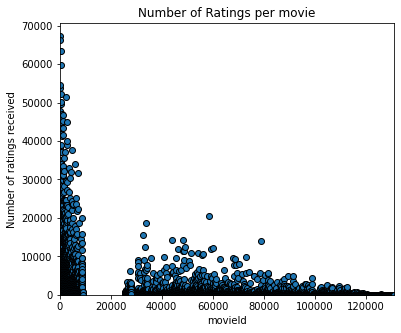

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.scatter(rating_count.index, rating_count.rating, edgecolor='black')
plt.xlim(0,rating_count.index.max())
plt.ylim(0,)
plt.title('Number of Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

We can observe a significant difference between the number of ratings received for different movies, ranging from around 70,000 ratings for the most popular movies to around a single rating for some unpopular movies.

Hence, we will use only those movies that have received more than atleast 5000 user ratings in our recommendation system. This will help us focus on recommending more popular movies, as well as help us increase training and prediction speed.

In [0]:
import numpy as np
top_movies = ratings_df[ratings_df.groupby('movieId')['rating'].transform('size')>5000]
top_movies

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5
...,...,...,...
20000243,138493,53996,4.5
20000249,138493,59315,4.0
20000252,138493,60069,4.0
20000258,138493,68954,4.5


We will now merge our ratings and movies databases to get a single dataframe that will be used from now.

In [0]:
data = pd.merge(movie_df,top_movies)
print(data.shape)
data

(12865416, 5)


,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5
...,...,...,...,...,...
12865411,81845,"King's Speech, The (2010)",Drama,138386,4.0
12865412,81845,"King's Speech, The (2010)",Drama,138406,4.0
12865413,81845,"King's Speech, The (2010)",Drama,138435,4.0
12865414,81845,"King's Speech, The (2010)",Drama,138446,4.0


In [0]:
n_users = len(data.userId.unique())
n_movies = len(data.movieId.unique())
min_rating = min(data['rating'])
max_rating = max(data['rating'])
print("No of unique users:", n_users)
print("No of unique movies: ", n_movies)
print("Minimum Rating: ", min_rating)
print("Maximum Rating:", max_rating)

No of unique users: 138476
No of unique movies:  1005
Minimum Rating:  0.5
Maximum Rating: 5.0


Let's also observe the frequency of each rating value in our dataset:

Frequency of each rating from 0.5 to 5.0:



Text(0.5, 0, 'Ratings')

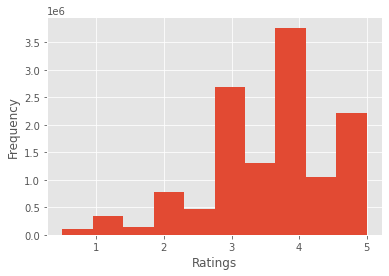

In [0]:
print("Frequency of each rating from 0.5 to 5.0:\n")
import matplotlib.pyplot as plt
plt.style.use('ggplot')
data['rating'].plot(kind = 'hist', bins = 10)
plt.xlabel('Ratings')

We can observe that most users rate movies in the range of 3 to 5, with 4 being the most common ratings. 

Now, we can also observe that the userIds and movieIds are not continuous in our dataset. Hence, we can use SKLearn's Label Encoders to assign unique sequential IDs starting at zero, which is required later in our model.

In [0]:
from sklearn.preprocessing import LabelEncoder

LE_user = LabelEncoder()
LE_movie = LabelEncoder()
data['UniqueUserId'] = LE_user.fit_transform(data['userId'].values)
data['UniqueMovieId'] = LE_movie.fit_transform(data['movieId'].values)
data

,movieId,title,genres,userId,rating,UniqueUserId,UniqueMovieId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,2,0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,5,0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,7,0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,9,0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,10,0
...,...,...,...,...,...,...,...
12865411,81845,"King's Speech, The (2010)",Drama,138386,4.0,138368,1004
12865412,81845,"King's Speech, The (2010)",Drama,138406,4.0,138388,1004
12865413,81845,"King's Speech, The (2010)",Drama,138435,4.0,138417,1004
12865414,81845,"King's Speech, The (2010)",Drama,138446,4.0,138428,1004


Let us also make a few functions for ease of conversion between these values that will be required later.

In [0]:
data_np = data.to_numpy()
print(data_np)
def movieId_to_title(id):
  for row in data_np:
    if row[0] == id:
      title = row[1]
      return title

def unique_movieId_to_title(uid):
  for row in data_np:
    if row[6] == uid:
      title = row[1]
      return title

def movieId_to_unique_movieId(id):
  for row in data_np:
    if row[0] == id:
      uid = row[6]
      return uid

def unique_movieId_to_movieId(uid):
  for row in data_np:
    if row[6] == uid:
      id = row[1]
      return id

[[1 'Toy Story (1995)' 'Adventure|Animation|Children|Comedy|Fantasy' ...
  4.0 2 0]
 [1 'Toy Story (1995)' 'Adventure|Animation|Children|Comedy|Fantasy' ...
  5.0 5 0]
 [1 'Toy Story (1995)' 'Adventure|Animation|Children|Comedy|Fantasy' ...
  4.0 7 0]
 ...
 [81845 "King's Speech, The (2010)" 'Drama' ... 4.0 138417 1004]
 [81845 "King's Speech, The (2010)" 'Drama' ... 4.0 138428 1004]
 [81845 "King's Speech, The (2010)" 'Drama' ... 4.0 138454 1004]]


We will now create our ( [UserId, MovieId] , Rating) pairing of data and label that will be input into our model for training. We will not be using a testing or a validation dataset, as our end objective is not to make accurate predictions on new data, but learn the best entitiy embeddings.

In [0]:
X = data[['UniqueUserId', 'UniqueMovieId']].values
y = data['rating'].values
# print("Input = ['UniqueUserId', 'UniqueMovieId'] :\n", X, "\n")
X_array = [X[:, 0], X[:, 1]]
print("Input (X_combined): ", X_array, "\n")
print("Output (Rating) :", y, "\n")

Input (X_combined):  [array([     2,      5,      7, ..., 138417, 138428, 138454]), array([   0,    0,    0, ..., 1004, 1004, 1004])] 

Output (Rating) : [4. 5. 4. ... 4. 4. 4.] 



In [0]:
from keras.layers import Input, Dot, Reshape, Dense, Add, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

def Movie_Embedding_Network(n_users, n_movies, embedding_size, min_rating, max_rating):
  
  #Input -> UserId followed by movieId
  users = Input(name = 'users', shape = (1,))
  movies = Input(name = 'movies', shape = (1,))

  #Create Embedding Layers
  users_embedding = Embedding(name = 'users_embeddings', input_dim = n_users, output_dim = embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.000001))(users)
  movies_embedding = Embedding(name = 'movies_embeddings', input_dim = n_movies, output_dim = embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.000001))(movies)

  #Reshaping the Embedding Layers
  reshaped_users_embedding = Reshape((embedding_size,), name = 'reshaped_users_embeddings')(users_embedding)
  reshaped_movies_embedding = Reshape((embedding_size,), name = 'reshaped_movies_embeddings')(movies_embedding)

  #Taking the dot product of the two embedding layers
  merged = Dot(name = 'dot_product', normalize = True, axes = 1)([reshaped_movies_embedding, reshaped_users_embedding])

  #Creating Embedding layers of size (1) for calculating bias.
  movies_bias = Embedding(name = 'movies_bias', input_dim = n_movies, output_dim = 1, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.000001))(movies)
  users_bias = Embedding(name = 'users_bias', input_dim = n_users, output_dim = 1, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.000001))(users)

  #Reshaping the Bias Embedding Layers
  reshaped_movies_bias = Reshape((1,), name = 'reshaped_movies_bias')(movies_bias)
  reshaped_users_bias = Reshape((1,), name = 'reshaped_users_bias')(users_bias)

  #Adding the Bias Layers to our dot product merged layer
  merged_w_bias = Add(name = 'bias_addition')([merged, reshaped_movies_bias, reshaped_users_bias])

  # Running the output of our dot product layer through a sigmoid activation layer and then scaling the outputs to our rating range for non-linearity
  activated = Activation('sigmoid')(merged_w_bias)
  scaled = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(activated)

  model = Model(inputs=[users, movies], outputs=scaled)
  model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
  return model

embedding_size = 50
model = Movie_Embedding_Network(n_users, n_movies, embedding_size, min_rating, max_rating)
model.summary()

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movies (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
users (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
movies_embeddings (Embedding)   (None, 1, 50)        50250       movies[0][0]                     
__________________________________________________________________________________________________
users_embeddings (Embedding)    (None, 1, 50)        6923800     users[0][0]                      
____________________________________________________________________________________________

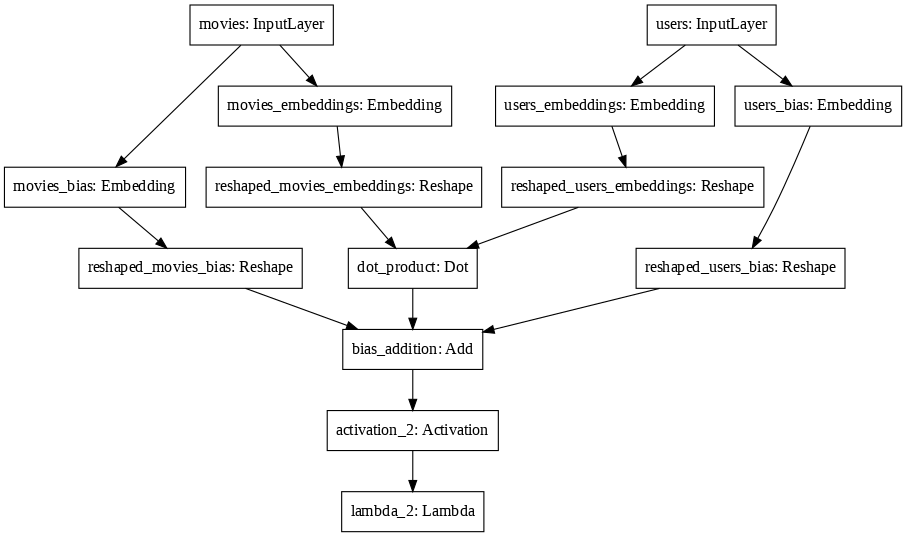

In [0]:
from keras.utils import plot_model
plot_model(model, rankdir= 'TR', dpi = 80)

We will use keras ModelCheckcoint for saving our best models which minimise the loss.

In [0]:
from keras.callbacks import ModelCheckpoint
filepath="/content/gdrive/My Drive/MovieLens/models/best_attempt.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [0]:
%time
epochs = 15

history = model.fit(x=X_array, y=y, epochs=epochs, batch_size=1000,
                    verbose=1, callbacks=callbacks_list)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 25 µs


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
12865416/12865416 [==============================] - 82s 6us/step - loss: 0.7610

Epoch 00001: loss improved from inf to 0.76105, saving model to /content/gdrive/My Drive/MovieLens/models/best_attempt.h5
Epoch 2/15
12865416/12865416 [==============================] - 83s 6us/step - loss: 0.6619

Epoch 00002: loss improved from 0.76105 to 0.66191, saving model to /content/gdrive/My Drive/MovieLens/models/best_attempt.h5
Epoch 3/15
12865416/12865416 [==============================] - 82s 6us/step - loss: 0.6506

Epoch 00003: loss improved from 0.66191 to 0.65056, saving model to /content/gdrive/My Drive/MovieLens/models/best_attempt.h5
Epoch 4/15
12865416/12865416 [==============================] - 82s 6us/step - loss: 0.6461

Epoch 00004: loss improved from 0.65056 to 0.64606, saving model to /content/gdrive/My Drive/MovieLens/models/best_attempt.h5
Epoch 5/15
12865416/12865416 [==============================] - 82s 6us/step - loss: 0.6437

Epoch 00005: loss improved from 0.6

In [0]:
#Loading Best Weights
model.load_weights("/content/gdrive/My Drive/MovieLens/models/best_attempt.h5")

In [0]:
#Saving Best Model
model.save("/content/gdrive/My Drive/MovieLens/models/best_attempt.h5")

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend('Training Loss', loc='upper left')
plt.show()

In [0]:
movie_layer = model.get_layer('movies_embeddings')
movie_weights = movie_layer.get_weights()[0]
print(movie_weights.shape)
print(movie_weights[0])

(1005, 50)
[ 6.1439537e-02 -3.0620437e-02  3.9664090e-01  7.9392865e-02
  1.0027196e-02 -1.5114629e-01 -1.0758323e-02 -2.9554635e-01
  1.0719966e-01  4.3641320e-01  8.4576540e-02  7.6303616e-02
 -4.6817437e-02  1.5436050e-01  4.1761431e-01 -1.9560184e-01
 -3.1581684e-03  4.7614295e-02 -4.3061629e-01 -8.8457502e-03
  9.4884103e-03 -1.5063885e-02 -1.5367492e-01  9.9029252e-03
 -4.1377538e-01 -6.1797595e-01  4.1146588e-02  1.2428828e-02
 -3.4622852e-02 -2.8773380e-02  3.8150340e-02  6.0612173e-03
  2.4369976e-02  3.1859937e-01  1.0604848e-02  2.7847311e-02
 -1.7459154e-02  1.6051047e-01 -7.2056106e-03  9.6692242e-02
  2.7510139e-01 -4.5386434e-01 -1.1785025e-01  1.8929635e-01
 -1.7593091e-02  2.2575270e-01 -4.5439991e-01  3.3088373e-03
  1.7066354e-01 -4.4676810e-04]


In [0]:
movie_weights_normalised = movie_weights / np.linalg.norm(movie_weights, axis = 1).reshape((-1, 1))
print(movie_weights_normalised[0])
np.sum(np.square(movie_weights_normalised[0]))

[ 4.08745483e-02 -2.03711893e-02  2.63877600e-01  5.28185517e-02
  6.67090155e-03 -1.00554734e-01 -7.15730619e-03 -1.96621329e-01
  7.13178813e-02  2.90337354e-01  5.62671535e-02  5.07633351e-02
 -3.11467443e-02  1.02693088e-01  2.77830809e-01 -1.30130157e-01
 -2.10106885e-03  3.16768773e-02 -2.86480755e-01 -5.88490814e-03
  6.31245784e-03 -1.00217136e-02 -1.02236979e-01  6.58822665e-03
 -2.75276840e-01 -4.11127567e-01  2.73740366e-02  8.26866087e-03
 -2.30339207e-02 -1.91423781e-02  2.53806915e-02  4.03241161e-03
  1.62128787e-02  2.11958066e-01  7.05520250e-03  1.85262822e-02
 -1.16152409e-02  1.06784537e-01 -4.79375478e-03  6.43274933e-02
  1.83019683e-01 -3.01947236e-01 -7.84035176e-02  1.25935242e-01
 -1.17043471e-02  1.50188938e-01 -3.02303553e-01  2.20130617e-03
  1.13539182e-01 -2.97226245e-04]


0.99999994

In [0]:
def movie_recommend(movieId, weights, n = 10):
  print("Printing recommendations for:", movieId_to_title(movieId), "\n\n")
  uid = movieId_to_unique_movieId(movieId)
  similarity = np.dot(weights, weights[uid])
  #print(similarity)
  sorted_sim = np.argsort(similarity)
  closest = sorted_sim[-n-1:-1]
  #print(closest)
  count = 0
  for i in reversed(closest):
    count = count + 1
    print(f'{count:{2}}: {unique_movieId_to_title(i):{80}} ---> Similarity: ", {(similarity[i]):{.2}}')

In [0]:
movie_recommend(1, movie_weights_normalised)

Printing recommendations for: Toy Story (1995) 


 1: Toy Story 2 (1999)                                                               ---> Similarity: ", 0.97
 2: Bug's Life, A (1998)                                                             ---> Similarity: ", 0.85
 3: Finding Nemo (2003)                                                              ---> Similarity: ", 0.83
 4: Monsters, Inc. (2001)                                                            ---> Similarity: ", 0.83
 5: Toy Story 3 (2010)                                                               ---> Similarity: ", 0.82
 6: Incredibles, The (2004)                                                          ---> Similarity: ", 0.79
 7: Aladdin (1992)                                                                   ---> Similarity: ", 0.77
 8: Beauty and the Beast (1991)                                                      ---> Similarity: ", 0.75
 9: Tarzan (1999)                                                     

In [0]:
movie_recommend(4896, movie_weights_normalised)

Printing recommendations for: Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001) 


 1: Harry Potter and the Chamber of Secrets (2002)                                   ---> Similarity: ", 0.98
 2: Harry Potter and the Goblet of Fire (2005)                                       ---> Similarity: ", 0.97
 3: Harry Potter and the Order of the Phoenix (2007)                                 ---> Similarity: ", 0.96
 4: Harry Potter and the Prisoner of Azkaban (2004)                                  ---> Similarity: ", 0.95
 5: Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)           ---> Similarity: ", 0.84
 6: Pirates of the Caribbean: At World's End (2007)                                  ---> Similarity: ", 0.72
 7: Pirates of the Caribbean: The Curse of the Black Pearl (2003)                    ---> Similarity: ", 0.7
 8: Pirates of the Caribbean: Dead Man's Chest (2006)                                ---> Similarity: "

In [0]:
movie_recommend(79132, movie_weights_normalised)

Printing recommendations for: Inception (2010) 


 1: Dark Knight, The (2008)                                                          ---> Similarity: ", 0.79
 2: Prestige, The (2006)                                                             ---> Similarity: ", 0.76
 3: Shutter Island (2010)                                                            ---> Similarity: ", 0.71
 4: V for Vendetta (2006)                                                            ---> Similarity: ", 0.69
 5: Batman Begins (2005)                                                             ---> Similarity: ", 0.68
 6: Lucky Number Slevin (2006)                                                       ---> Similarity: ", 0.65
 7: Departed, The (2006)                                                             ---> Similarity: ", 0.63
 8: 300 (2007)                                                                       ---> Similarity: ", 0.62
 9: Sherlock Holmes (2009)                                            

In [0]:
def movie_recommend_multiInput(movieIds, weights, n=10):
    recs = []
    for movieId in movieIds:
      uid = movieId_to_unique_movieId(movieId)
      similarity = np.dot(weights, weights[uid])
      #print(similarity)
      sorted_sim = np.argsort(similarity)
      closest = sorted_sim[-n-1:-1]
      #print(closest)
      count = 0
      for i in reversed(closest):
        recs.append({"Movie_Name":unique_movieId_to_title(i), "Similarity":similarity[i]})
    combined_recs_sorted = sorted(recs, key = lambda i: i['Similarity'])
    # print(combined_recs_sorted)
    for i in reversed(combined_recs_sorted[:10]):
      print(i)


In [0]:
movie_recommend_multiInput([1, 4896], movie_weights_normalised)

{'Movie_Name': 'Incredibles, The (2004)', 'Similarity': 0.7933394} 

{'Movie_Name': 'Aladdin (1992)', 'Similarity': 0.7748278} 

{'Movie_Name': 'Beauty and the Beast (1991)', 'Similarity': 0.75167006} 

{'Movie_Name': 'Tarzan (1999)', 'Similarity': 0.72616655} 

{'Movie_Name': "Pirates of the Caribbean: At World's End (2007)", 'Similarity': 0.72167724} 

{'Movie_Name': 'Babe (1995)', 'Similarity': 0.7180187} 

{'Movie_Name': 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)', 'Similarity': 0.6968948} 

{'Movie_Name': "Pirates of the Caribbean: Dead Man's Chest (2006)", 'Similarity': 0.69170195} 

{'Movie_Name': 'Ever After: A Cinderella Story (1998)', 'Similarity': 0.6694162} 

{'Movie_Name': 'X-Men: The Last Stand (2006)', 'Similarity': 0.64758587} 



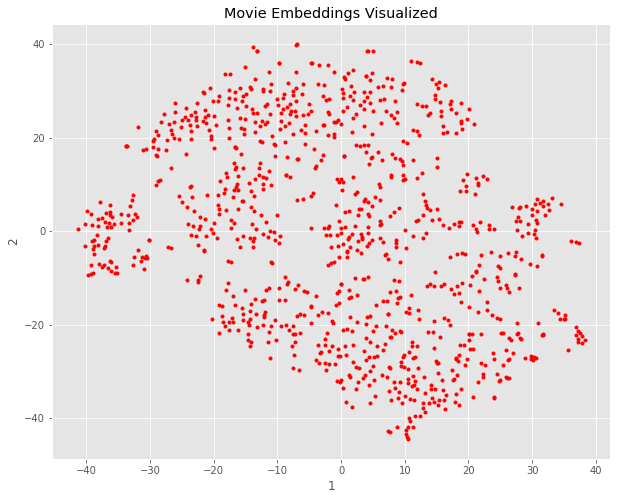

In [0]:
from sklearn.manifold import TSNE
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#Reduce dimensions of embeddings
def reduce_dim(weights, components):
    return TSNE(components, metric = 'cosine').fit_transform(weights)

movie_r = reduce_dim(movie_weights_normalised, components = 2)
movie_r.shape

plt.figure(figsize = (10, 8))
plt.plot(movie_r[:, 0], movie_r[:, 1], 'r.')
plt.xlabel('1'); plt.ylabel('2'); plt.title('Movie Embeddings Visualized');

In [0]:
import random
genres_list = data.loc[:,["UniqueMovieId","genres"]]
genres_list = genres_list.drop_duplicates()
# genres_list.to_numpy()
print(genres_list)

genre_index = []

def get_gen(gens):
  gen_to_include = ['comedy', 'drama', 'action', 'romance', 'sci-fi', 'horror', 'children']
  for i in gens:
    if i in gen_to_include:
      return i
    else:
      return gens[0]
for i in genres_list.iloc:
  gens = i[1]
  gens = list(gens.split('|'))
  genre_index.append({i[0]: get_gen(gens).lower()})
  #print(genre_index[:10])
print(genre_index[-10:])

genres = []

for i in genre_index:
  # if list(i.values())[0] not in set(genres):
  g = list(i.values())
  genres.append(g[0])
print(genres)


          UniqueMovieId                                            genres
0                     0       Adventure|Animation|Children|Comedy|Fantasy
49695                 1                        Adventure|Children|Fantasy
71938                 2                                    Comedy|Romance
84673                 3                                            Comedy
96834                 4                             Action|Crime|Thriller
...                 ...                                               ...
12829432           1000  Adventure|Animation|Children|Comedy|Fantasy|IMAX
12835213           1001   Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
12849236           1002                                             Drama
12854500           1003                                    Drama|Thriller
12859787           1004                                             Drama

[1005 rows x 2 columns]
[{995: 'mystery'}, {996: 'action'}, {997: 'action'}, {998: 'action'}, {999: 'drama'}, {

In [0]:
from collections import Counter, OrderedDict
def count_items(l):
    counts = Counter(l)
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)   
    return counts
    
# Remove genres not found
genre_counts = count_items(genres)
list(genre_counts.items())[:10]

[('action', 290),
 ('comedy', 270),
 ('drama', 188),
 ('adventure', 100),
 ('crime', 64),
 ('animation', 27),
 ('horror', 21),
 ('children', 14),
 ('mystery', 8),
 ('thriller', 6)]

['Adventure' 'Comedy' 'Action' 'Drama' 'Crime' 'Mystery' 'Children'
 'Animation' 'Horror' 'Thriller']


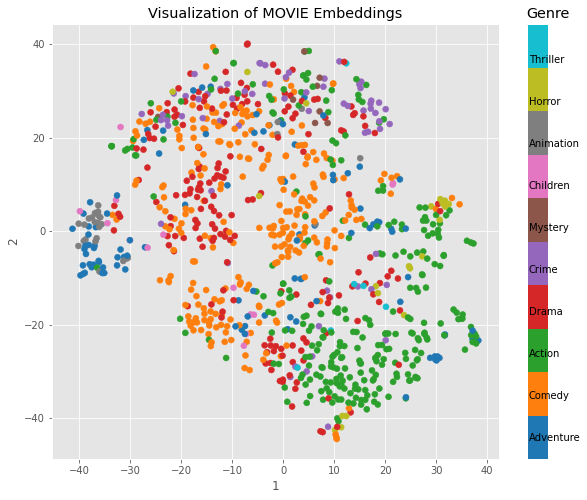

In [0]:
# Include 10 most popular genres
genre_to_include = list(genre_counts.keys())[:10]

idx_include = []
genres = []

for i in genre_index:
    if list(i.values())[0] in genre_to_include:
            idx_include.append(int(list(i.keys())[0]))
            genres.append(list(i.values())[0].capitalize())
            
len(idx_include)

ints, gen = pd.factorize(genres)
gen[:5]
plt.figure(figsize = (10, 8))

plt.scatter(movie_r[idx_include, 0], movie_r[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

cbar = plt.colorbar()
cbar.set_ticks([])
print(gen)
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((2.3) ), lab, ha='left', va='center')
cbar.ax.set_title('Genre', loc = 'left')

plt.xlabel('1'); plt.ylabel('2'); plt.title('Visualization of MOVIE Embeddings');